Please use the following cells to check if your GPU is accessible within this notebook

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.sysconfig.get_build_info() 

2023-07-15 22:59:43.172815: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-15 22:59:43.194344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 22:59:43.551689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-07-15 22:59:43.939738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-15 22:59:43.953698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-15 22:59:43.953787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

OrderedDict([('cpu_compiler', '/usr/lib/llvm-16/bin/clang'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.8'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

This repo provides a dockerfile for setting up a container to run this code in. Once that docker container is running, we will need some more installations before we can start building or training pipeline.

In [3]:
#should really be mostly "requirements already satisfied:" but just in case

# #some installations that our framework depends on 
# !pip install keras
# !pip install tifffile

# #for mask generation
# !pip install rasterio
# !pip install geopandas
# !pip install gdal
# !pip install opencv-python


Here we have torch to accomodate the framework we will be using. We will be training a Unet neural network for feature extraction and to generate mask images.

The repo we are using is modified slightly to accomodate this project folder structure and is a fork of [this repo](https://github.com/reachsumit/deep-unet-for-satellite-image-segmentation/)


In [5]:
!ls ~/deep-unet-for-satellite-image-segmentation

README.md    gen_patches.py  predict.py        train_unet.py	     weights
__pycache__  log_unet.csv    run.sbatch        unet_model.py
data	     map.tif	     tensorboard_unet  unet_model_deeper.py


We have already cloned the repo into our lib folder. If you need to do this you can use the git command with the link provided above

Ok now we have that repo locally. Before we start actually building the pipeline, lets see what our data looks like. Below I will print out a couple images to see what we are working with

In [1]:
import numpy as np
import matplotlib.pyplot as plt # display image
from rasterio.plot import reshape_as_image
from osgeo import gdal
import os
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


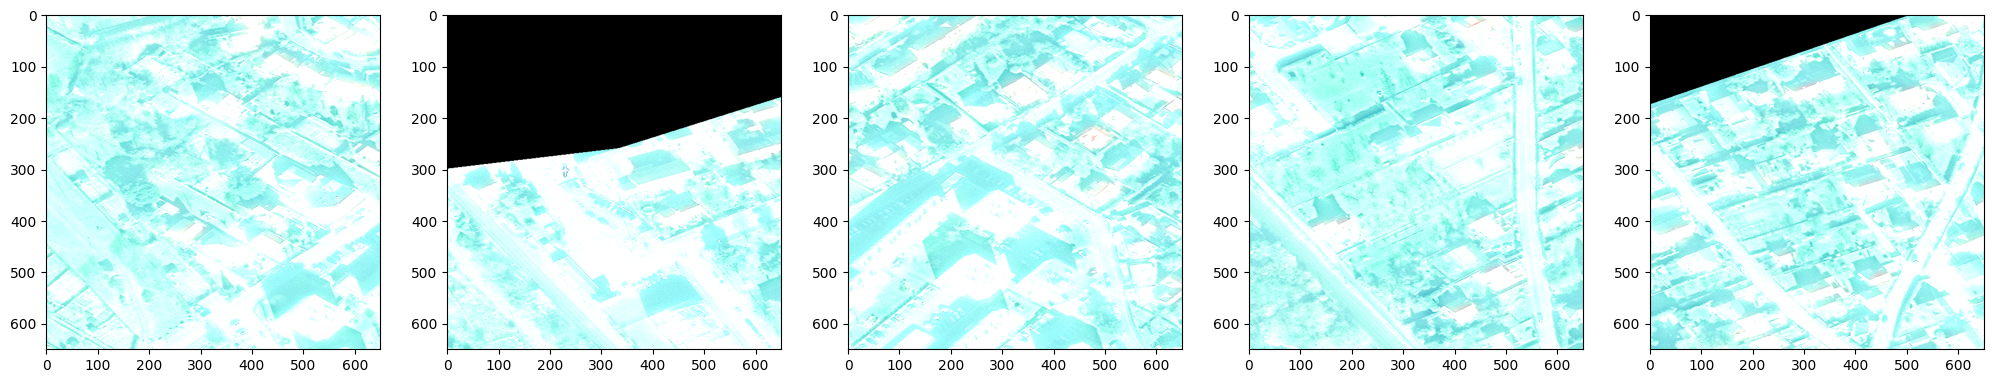

In [7]:
filelocs = ['/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img100.tif',
            '/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img107.tif',
            '/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img111.tif',
            '/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img128.tif',
            '/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img158.tif']
# Read File Raster Data as Array using Gdal
rasters = []
for x in filelocs:
    gtif = gdal.Open(x)
    rasters.append(gtif.ReadAsArray())

plt.subplots(1,5,figsize=(25,5))
for i in range(0,len(rasters)):
    plt.subplot(1,5,i+1)
    plt.imshow(reshape_as_image(rasters[i]))

Similarly, there is a folder of geojson files that contain regions for the buildings that appear in these pictures. Keep in mind that some images dont have any buildings, and this can be seen in their corresponding geojson files. The files with buildings typically have entries in the features tag whereas those with out buildings predictably don't have any such features. Here are two examples of this

In [8]:
print("File with no buildings\n")
%cat ~/data/train/geojson/buildings/buildings_AOI_3_Paris_img3.geojson | head -5

print("File with buildings\n")
%cat ~/data/train/geojson/buildings/buildings_AOI_3_Paris_img100.geojson | head -5

File with no buildings

{
"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
                                                                                
"features": [
File with buildings

{
"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
                                                                                
"features": [


You can see that one json is small and has no features whereas the other has about 30 features

Alright now here is maybe the hardest part of the pipeline creation, we have to format our data a little. We need to convert the geojsons that we have to json. Once that is done, the hard part is over. All we need to do is feed this data to the train script we have obtained from Unet. After that we are ready to test the model on our other set of data. 

Using [this](https://lpsmlgeo.github.io/2019-09-22-binary_mask/#4-generate-the-binary-mask) link, we have modified the code that is provided there to generate masks for us, and the py file for this is provided in this repo as generate_masks_from_geojson.py. 

In [9]:
#Use this as needed in case you need to reset the masks folder
!rm ~/data/train/Masks/*

In [10]:

paths = ["/home/jovyan/data/train/geojson/buildings" , #geojsons
         "/home/jovyan/data/train/RGB-PanSharpen", #tifs
         "/home/jovyan/data/train/Masks"] #output dir
!python3 ~/src/generate_masks_from_geojson.py {paths[0]} {paths[1]} {paths[2]}


tifDirList length: 1148

Creating output directory if it doesnt exist

Already Exists: /home/jovyan/data/train/Masks

Commencing mask gen

Mask gen complete. 1148 masks made. Please check your directory


Lets see if it worked

In [11]:
import os
print(os.listdir("/home/jovyan/data/train/Masks")[:10])

['buildings_AOI_3_Paris_img1879.tif', 'buildings_AOI_3_Paris_img595.tif', 'buildings_AOI_3_Paris_img680.tif', 'buildings_AOI_3_Paris_img543.tif', 'buildings_AOI_3_Paris_img337.tif', 'buildings_AOI_3_Paris_img586.tif', 'buildings_AOI_3_Paris_img1057.tif', 'buildings_AOI_3_Paris_img648.tif', 'buildings_AOI_3_Paris_img1647.tif', 'buildings_AOI_3_Paris_img1320.tif']


The directory shows that images were indeed made at the location we specified. Lets now see the images and their corresponding masks.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(650, 650)


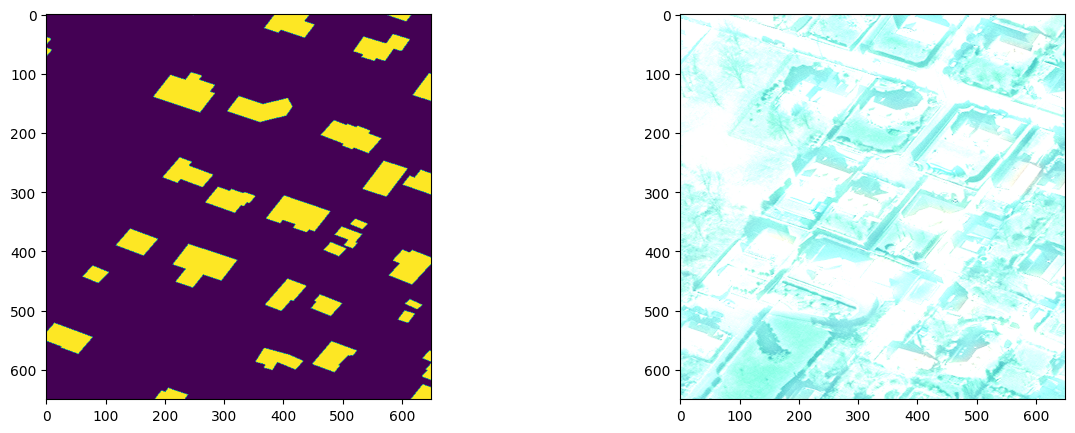

In [12]:

gtif = gdal.Open('/home/jovyan/data/train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img746.tif')
image = gtif.ReadAsArray()

gtif = gdal.Open('/home/jovyan/data/train/Masks/buildings_AOI_3_Paris_img746.tif')
mask = gtif.ReadAsArray()
print(mask.shape)

plt.subplots(1,2,figsize=(15,5))
plt.imshow(reshape_as_image(image))
plt.subplot(1,2,1)
plt.imshow(reshape_as_image([mask]))
plt.subplot(1,2,2)
plt.show()

gtif = None

Here is one example of a mask made for the image above it. It shows the network where the pixels that belong to buildings are. Using this data, we will now train Unet.

We need to make some modifications to the repo that we downloaded earlier. Namely some of the hyperparameters like Band Size and Number of Classes, as well as all the path strings so they match the current set up. After this is all done. Simply invoke the script and it should start training a model. 

Since we have a large number of images (1000+), I have set it so that it will only look at the first 500 images. For each batch it takes 50 from the 500.the model augments the data by taking 160x160 size patches from the batch 1000 times. So for each batch it ends up looking at 1000 160x160 crops from the 50 images in a batch. It will do this 10000 times (10000 Epochs) so that it can  get a good understanding of the data.

Alright now that we understand some of the specifics of what it is doing, lets uncomment and run the script.

In [ ]:
!python3 ~/deep-unet-for-satellite-image-segmentation/train_unet.py

2023-07-15 23:03:35.599133: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-15 23:03:35.619709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 23:03:35.966040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-15 23:03:36.352980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

145	RGB-PanSharpen_AOI_3_Paris_img6.tif read
146	RGB-PanSharpen_AOI_3_Paris_img975.tif read
147	RGB-PanSharpen_AOI_3_Paris_img1692.tif read
148	RGB-PanSharpen_AOI_3_Paris_img1429.tif read
149	RGB-PanSharpen_AOI_3_Paris_img867.tif read
150	RGB-PanSharpen_AOI_3_Paris_img819.tif read
151	RGB-PanSharpen_AOI_3_Paris_img1140.tif read
152	RGB-PanSharpen_AOI_3_Paris_img1197.tif read
153	RGB-PanSharpen_AOI_3_Paris_img914.tif read
154	RGB-PanSharpen_AOI_3_Paris_img1170.tif read
155	RGB-PanSharpen_AOI_3_Paris_img1822.tif read
156	RGB-PanSharpen_AOI_3_Paris_img1506.tif read
157	RGB-PanSharpen_AOI_3_Paris_img991.tif read
158	RGB-PanSharpen_AOI_3_Paris_img1800.tif read
159	RGB-PanSharpen_AOI_3_Paris_img1489.tif read
160	RGB-PanSharpen_AOI_3_Paris_img372.tif read
161	RGB-PanSharpen_AOI_3_Paris_img1109.tif read
162	RGB-PanSharpen_AOI_3_Paris_img182.tif read
163	RGB-PanSharpen_AOI_3_Paris_img1396.tif read
164	RGB-PanSharpen_AOI_3_Paris_img418.tif read
165	RGB-PanSharpen_AOI_3_Paris_img334.tif read
166	

324	RGB-PanSharpen_AOI_3_Paris_img1108.tif read
325	RGB-PanSharpen_AOI_3_Paris_img403.tif read
326	RGB-PanSharpen_AOI_3_Paris_img1330.tif read
327	RGB-PanSharpen_AOI_3_Paris_img1124.tif read
328	RGB-PanSharpen_AOI_3_Paris_img1114.tif read
329	RGB-PanSharpen_AOI_3_Paris_img158.tif read
330	RGB-PanSharpen_AOI_3_Paris_img1076.tif read
331	RGB-PanSharpen_AOI_3_Paris_img887.tif read
332	RGB-PanSharpen_AOI_3_Paris_img941.tif read
333	RGB-PanSharpen_AOI_3_Paris_img735.tif read
334	RGB-PanSharpen_AOI_3_Paris_img50.tif read
335	RGB-PanSharpen_AOI_3_Paris_img903.tif read
336	RGB-PanSharpen_AOI_3_Paris_img500.tif read
337	RGB-PanSharpen_AOI_3_Paris_img380.tif read
338	RGB-PanSharpen_AOI_3_Paris_img780.tif read
339	RGB-PanSharpen_AOI_3_Paris_img1038.tif read
340	RGB-PanSharpen_AOI_3_Paris_img147.tif read
341	RGB-PanSharpen_AOI_3_Paris_img506.tif read
342	RGB-PanSharpen_AOI_3_Paris_img841.tif read
343	RGB-PanSharpen_AOI_3_Paris_img1740.tif read
344	RGB-PanSharpen_AOI_3_Paris_img1011.tif read
345	RG

Generated 1500 patches
Generated 500 patches
2023-07-15 23:03:39.621315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-15 23:03:39.621495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-15 23:03:39.621537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/l

Now we have a Model saved in a weights folder in our directory. Now we will try and test this model on a random image in the test data set. 

The predict fscript takes 2 parameters. The name of the model file that you want to use, or "latest" if u want to use the latest model. And it takes the name of the image that you want to make a prediction for. We have just set it to take a random image from the test set every time.

rm: cannot remove '/home/jovyan/work/output/*': No such file or directory


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2023-07-15 22:47:37.386804: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-15 22:47:37.408775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 22:47:37.705970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-15 22:47:38.140878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

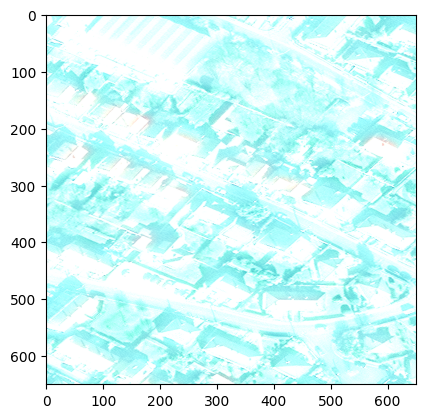

In [6]:
!rm /home/jovyan/work/output/*

randimgnum = random.randint(0,len(os.listdir("/home/jovyan/data/test/PS-RGB/")))
img2show = os.listdir("/home/jovyan/data/test/PS-RGB/")[randimgnum]
gtif = gdal.Open("/home/jovyan/data/test/PS-RGB/" + img2show)
image = gtif.ReadAsArray()
plt.imshow(reshape_as_image(image))

!python3 ~/deep-unet-for-satellite-image-segmentation/predict.py latest {img2show}

Ok we just generated a prediction for the image shown above. Lets see what it looks like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


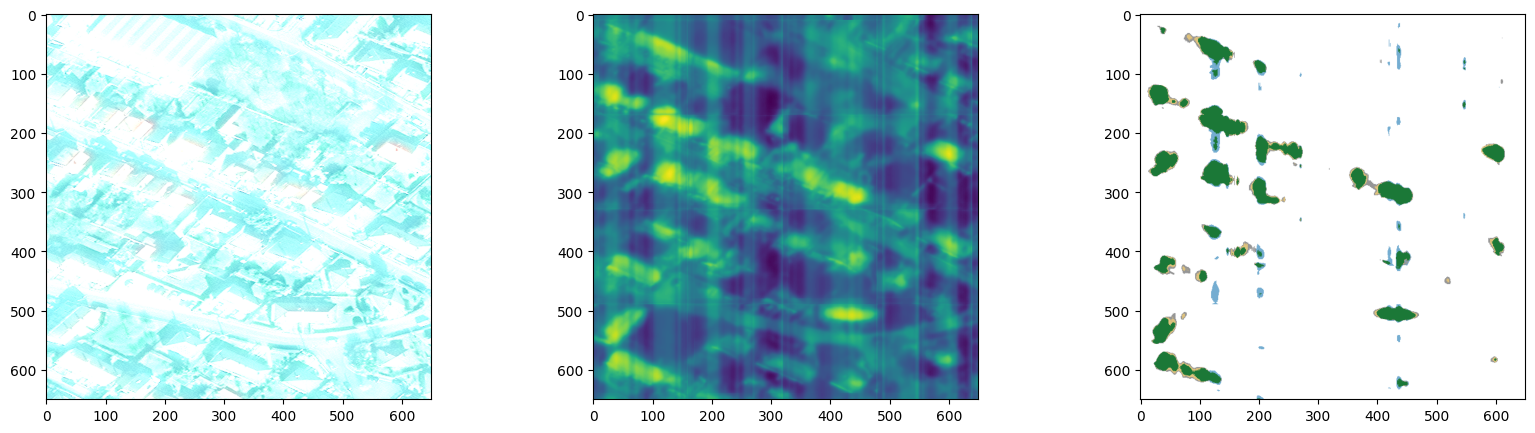

In [9]:
gtif = gdal.Open('/home/jovyan/output/result.tif')
result = gtif.ReadAsArray()

gtif = gdal.Open('/home/jovyan/output/map.tif')
map = gtif.ReadAsArray()

plt.subplots(1,3,figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(reshape_as_image(image))
plt.subplot(1,3,2)
plt.imshow(result)
plt.subplot(1,3,3)
plt.imshow(reshape_as_image(map))
plt.show()

gtif = None

Well, as you can see the prediction is not that great.